Column
    [0] Markdown(str)
    [1] Row
        [0] Select(name='Campus', options=['All', 'BX', ...], value='All')
        [1] Select(name='Part Term', options=['All', 'A', 'A1', ...], value='All')
    [2] ParamFunction(function, _pane=Matplotlib, defer_load=False)
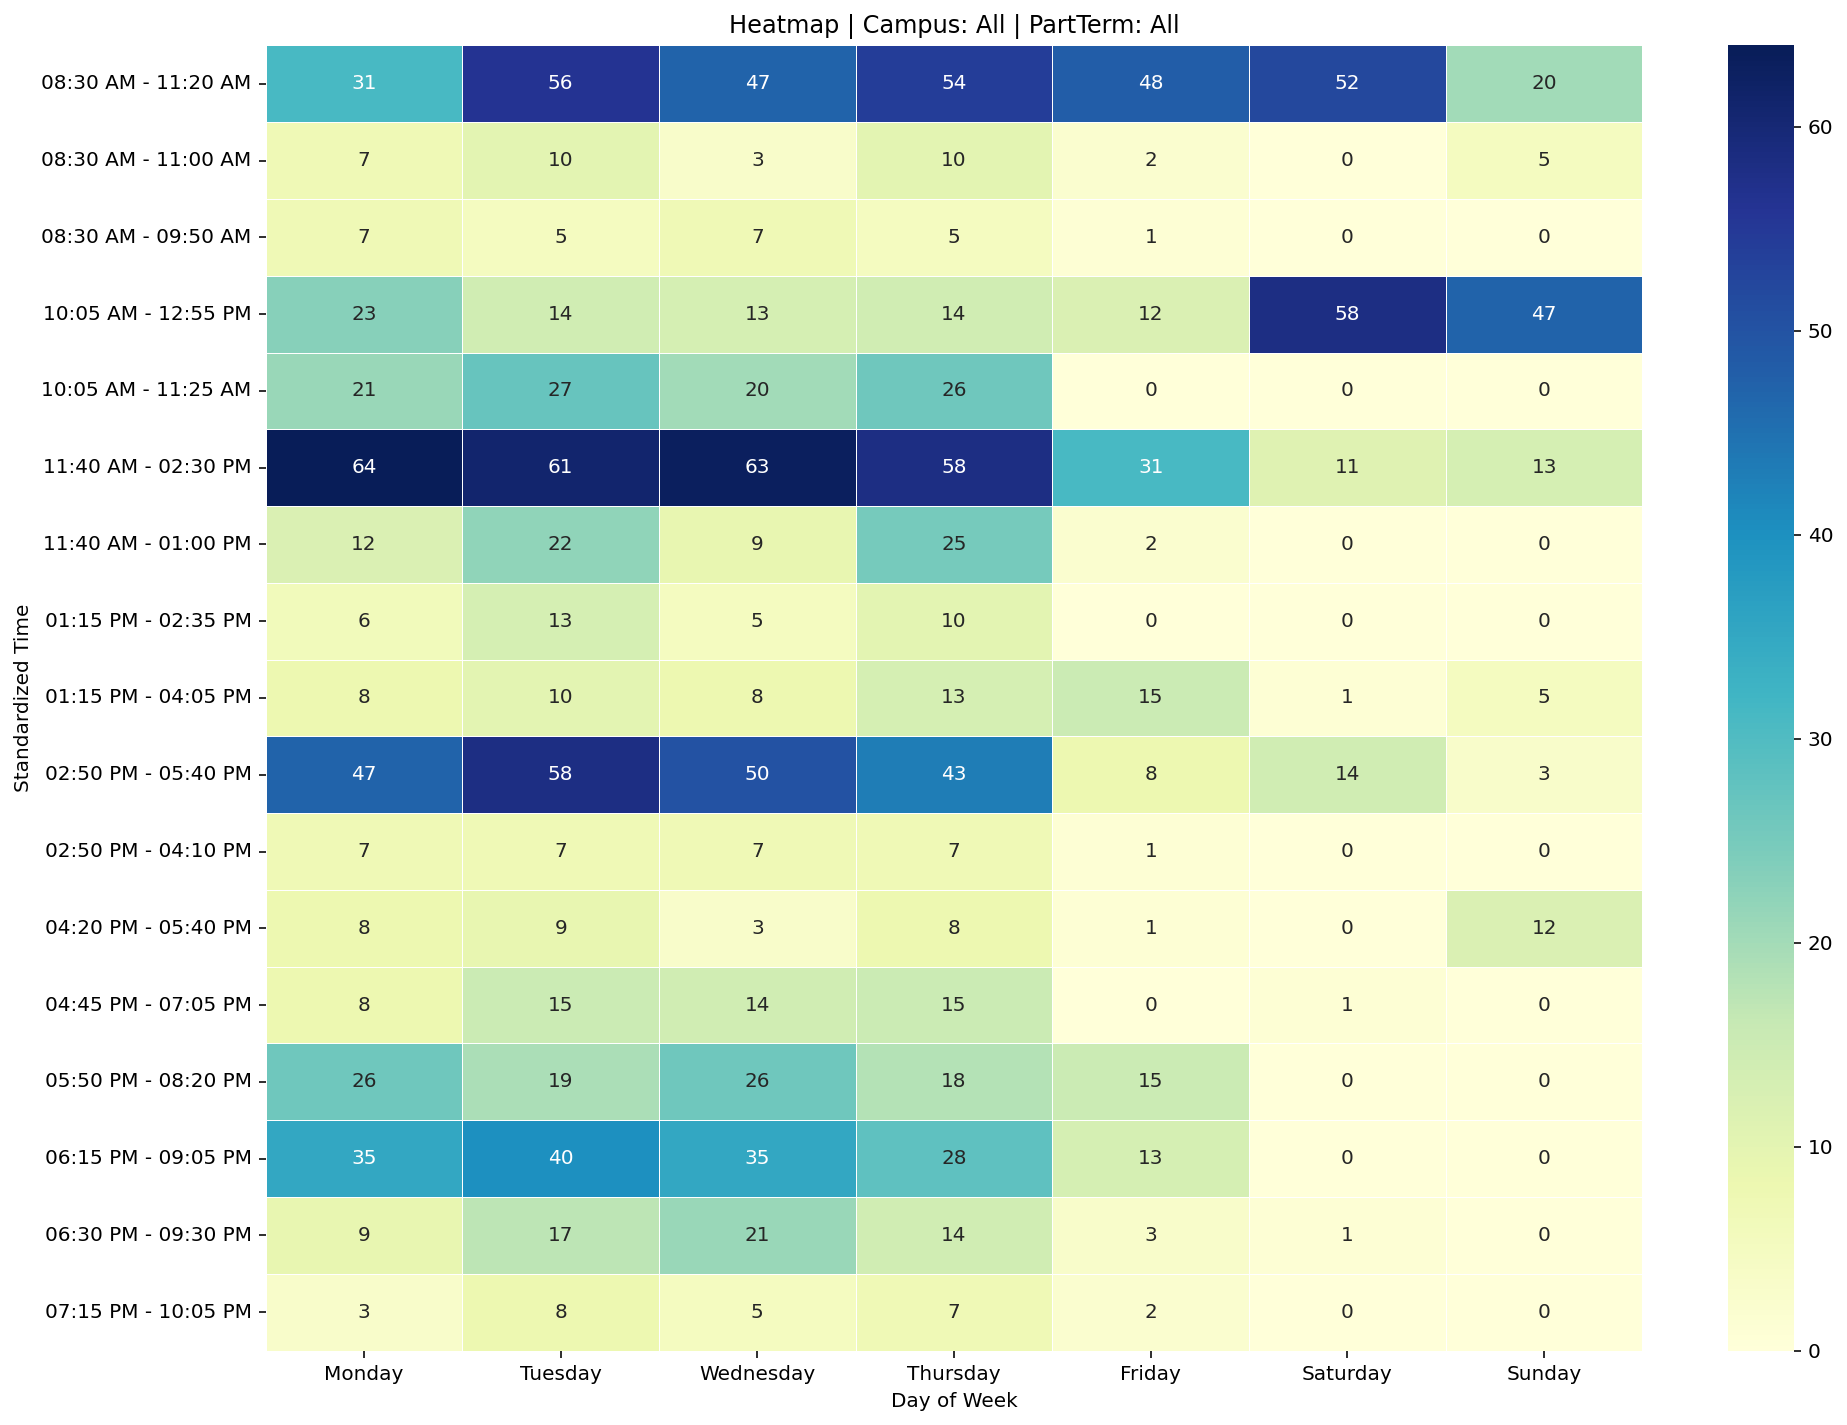

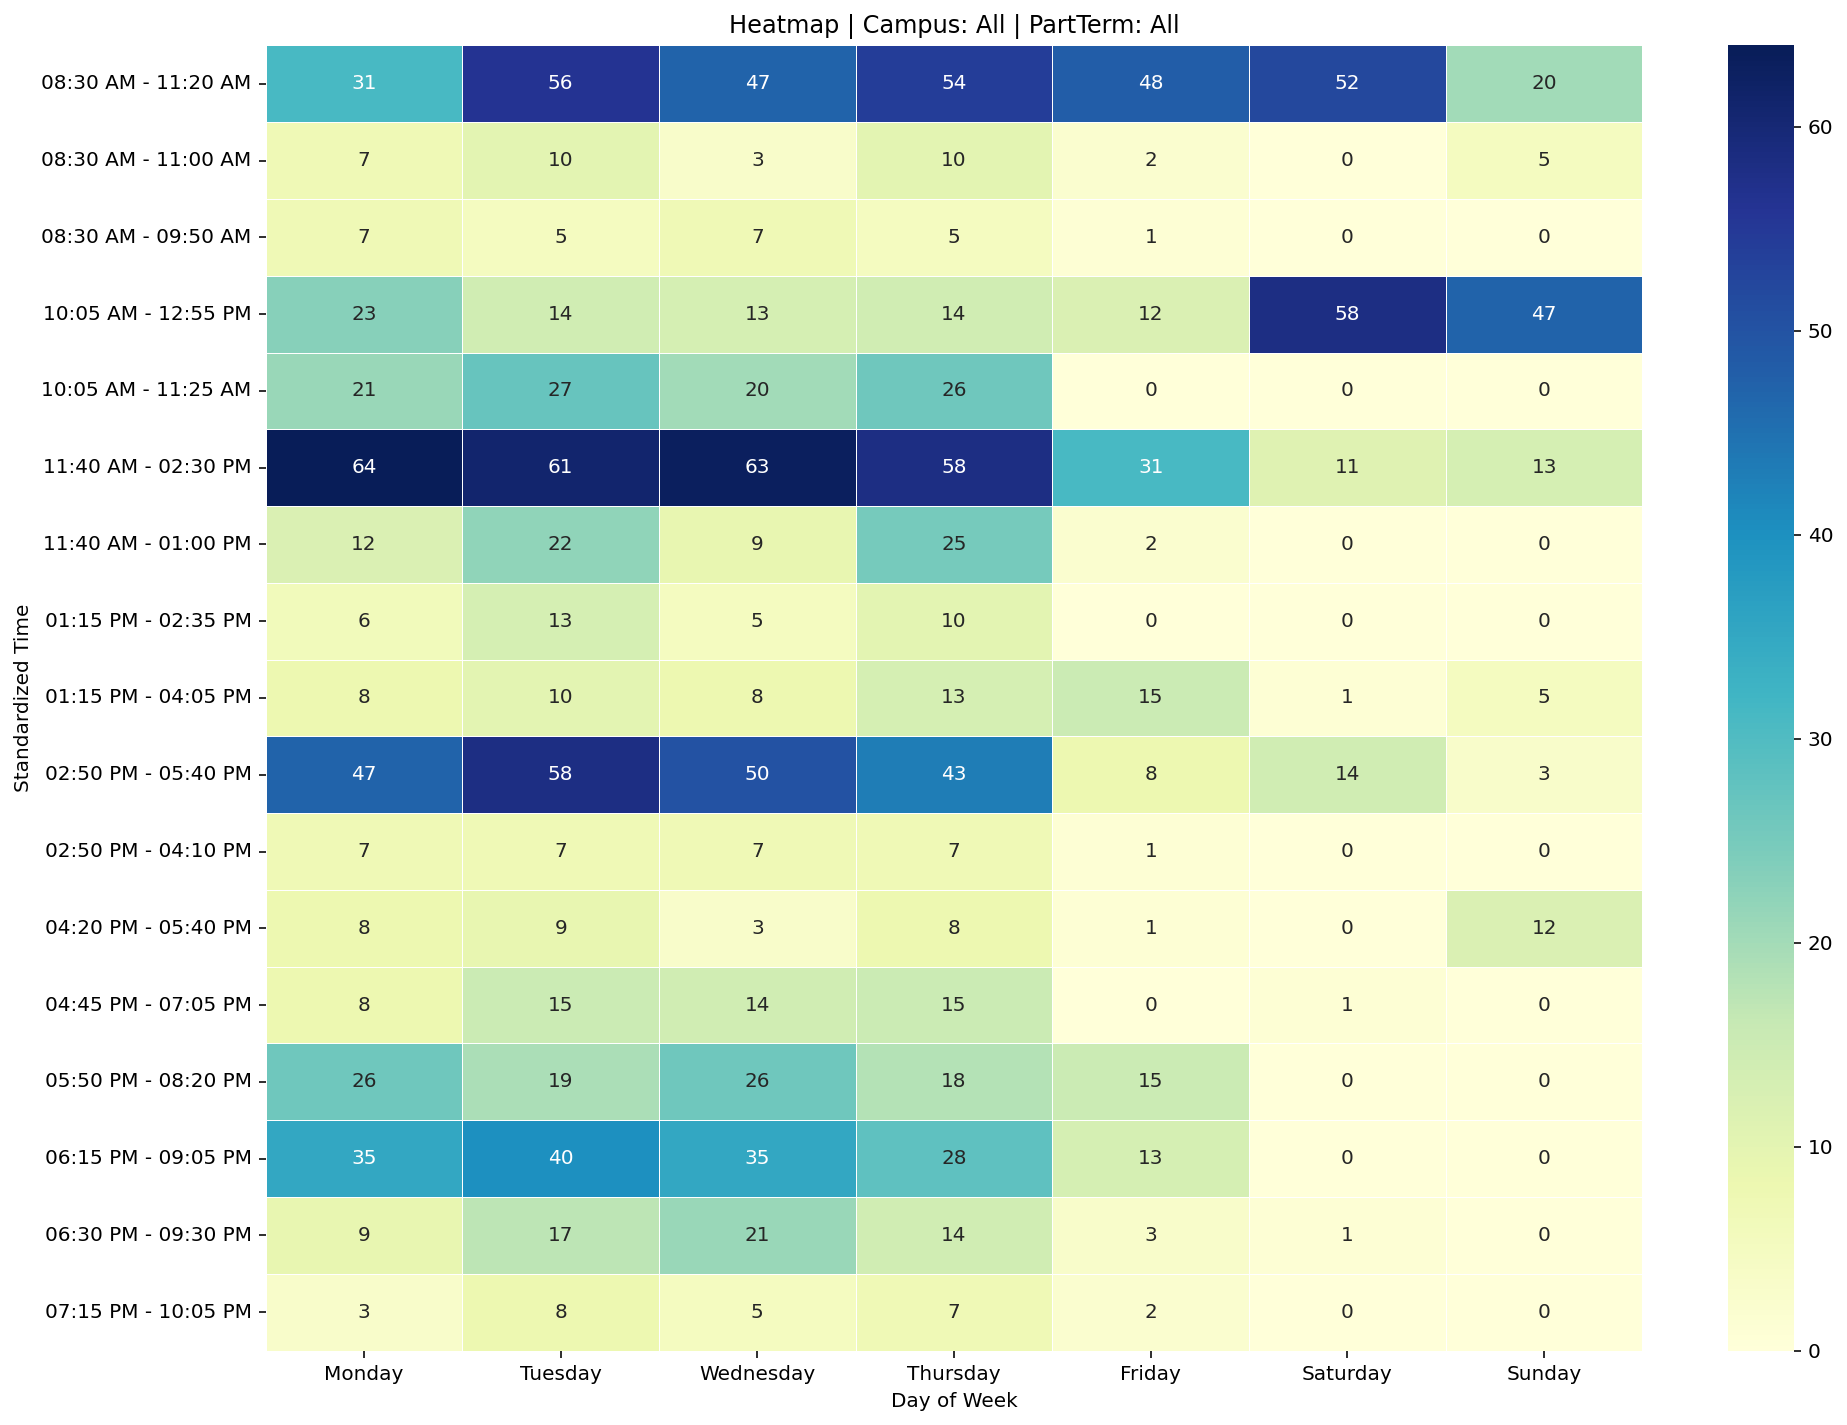

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import panel as pn
pn.extension()

# Load and clean data
df = pd.read_csv('Spring_2025_schedule_standardized.csv')

# Standard filtering
df = df[df['CRSSTATUS'] == 'Active']
df = df[~df['INST_METHOD'].isin(['WB', 'MM'])]
df = df[~df['CAMPUS'].isin(['GU', 'HS'])]
df = df[~df['PARTTERM'].isin(['K', 'HS'])]
df = df[df['MTGDAYS'].notna() & df['Standardized_Time'].notna()]
df = df[~df['MTGDAYS'].str.upper().eq('TBA')]
df = df[~df['Standardized_Time'].str.upper().eq('TBA')]

# Create selector options
campus_options = ['All'] + sorted(df['CAMPUS'].unique())
partterm_options = ['All'] + sorted(df['PARTTERM'].unique())

# Define widgets
campus_select = pn.widgets.Select(name='Campus', options=campus_options, value='All')
partterm_select = pn.widgets.Select(name='Part Term', options=partterm_options, value='All')

# Plotting function
def plot_heatmap(campus, partterm):
    filtered_df = df.copy()
    if campus != 'All':
        filtered_df = filtered_df[filtered_df['CAMPUS'] == campus]
    if partterm != 'All':
        filtered_df = filtered_df[filtered_df['PARTTERM'] == partterm]

    # Expand MTGDAYS into rows
    days_map = {'M': 'Monday', 'T': 'Tuesday', 'W': 'Wednesday',
                'R': 'Thursday', 'F': 'Friday', 'S': 'Saturday', 'U': 'Sunday'}

    expanded_rows = []
    for _, row in filtered_df.iterrows():
        for d in row['MTGDAYS']:
            if d in days_map:
                expanded_rows.append({
                    'Day': days_map[d],
                    'Standardized_Time': row['Standardized_Time']
                })

    heatmap_df = pd.DataFrame(expanded_rows)

    if heatmap_df.empty:
        return pn.pane.Markdown("**No data to display.**")

    pivot_table = heatmap_df.groupby(['Standardized_Time', 'Day']).size().unstack(fill_value=0)
    ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    pivot_table = pivot_table.reindex(columns=ordered_days, fill_value=0)

    def time_sort_key(time_range):
        try:
            start_time = time_range.split(' - ')[0]
            return datetime.strptime(start_time.strip(), '%I:%M %p')
        except:
            return datetime.strptime('12:00 AM', '%I:%M %p')

    pivot_table = pivot_table.sort_index(key=lambda x: x.map(time_sort_key))

    # Plotting
    fig, ax = plt.subplots(figsize=(14, 10))
    sns.heatmap(pivot_table, cmap="YlGnBu", linewidths=.5, annot=True, fmt=".0f", ax=ax)
    ax.set_title(f"Heatmap | Campus: {campus} | PartTerm: {partterm}")
    ax.set_xlabel('Day of Week')
    ax.set_ylabel('Standardized Time')
    plt.tight_layout()

    return pn.pane.Matplotlib(fig, tight=True)

# Bind function to widgets
interactive_panel = pn.bind(plot_heatmap, campus=campus_select, partterm=partterm_select)

# Layout
dashboard = pn.Column(
    "# 📊 Spring 2025 Schedule Heatmap (Panel)",
    pn.Row(campus_select, partterm_select),
    interactive_panel
)

dashboard.servable()
